In [1]:
# test the idea of vectorized cross correlation for 
# strided images, rectangular windows and extended search area
# in one function

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import rfft2, irfft2

In [3]:
from openpiv.pyprocess import moving_window_array, \
                            normalize_intensity,\
                            fft_correlate_strided_images, \
                            find_subpixel_peak_position
from openpiv.tools import imread

In [4]:
def get_field_shape(image_size, search_area_size, overlap):
    """Compute the shape of the resulting flow field.

    Given the image size, the interrogation window size and
    the overlap size, it is possible to calculate the number
    of rows and columns of the resulting flow field.

    Parameters
    ----------
    image_size: two elements tuple
        a two dimensional tuple for the pixel size of the image
        first element is number of rows, second element is
        the number of columns, easy to obtain using .shape

    search_area_size: tuple
        the size of the interrogation windows (if equal in frames A, B) or 
        the search area (in frame B), the largest  of the two

    overlap: tuple
        the number of pixel by which two adjacent interrogation
        windows overlap.


    Returns
    -------
    field_shape : three elements tuple
        the shape of the resulting flow field
    """
    field_shape = (np.array(image_size) - np.array(search_area_size)) // \
                  (np.array(search_area_size) - np.array(overlap)) + 1
    return field_shape

In [5]:
def correlation_to_velocity(corr, n_rows, n_cols, search_area_size=32):
    # iterate through interrogation widows and search areas
    u = np.zeros((n_rows, n_cols))
    v = np.zeros((n_rows, n_cols))
    
    for k in range(n_rows):
        for m in range(n_cols):
            
            row, col = find_subpixel_peak_position(corr[k*n_cols+m,:,:])
            
            row -= (2*search_area_size - 1) // 2
            col -= (2*search_area_size - 1) // 2

            # get displacements, apply coordinate system definition
            u[k, m], v[k, m] = -col, row
            
    return (u,v)

In [6]:
frame_a = imread('../test1/exp1_001_a.bmp')
frame_b = imread('../test1/exp1_001_b.bmp')

# frame_a = frame_a[:64,:64]
# frame_b = frame_b[:64,:64]

frame_a = normalize_intensity(frame_a)
frame_b = normalize_intensity(frame_b)

In [7]:
# for debugging purposes 
# frame_a = frame_a[:64,:64]
# frame_b = frame_b[:64,:64]

In [8]:
# parameters for the test
window_size = 32
overlap = 16
search_size = window_size #not extended search for a while

In [9]:
# for the regular square windows case:
aa = moving_window_array(frame_a, window_size, overlap)
bb = moving_window_array(frame_b, window_size, overlap)

In [10]:
c = fft_correlate_strided_images(aa,bb)
n_rows, n_cols = get_field_shape(frame_a.shape, search_size, overlap)
u,v = correlation_to_velocity(c, n_rows,n_cols,search_area_size=window_size)

In [11]:
# let's assume we want the extended search type of PIV analysis
# with search_area_size in image B > window_size in image A
window_size = 16
overlap = 16
search_size = 32  

In [12]:
# for the regular square windows case:
aa = moving_window_array(frame_a, search_size, overlap)
bb = moving_window_array(frame_b, search_size, overlap)

In [13]:
mask = np.zeros((search_size,search_size))
pad = np.int((search_size - window_size) / 2)

In [14]:
mask[slice(pad,search_size-pad),slice(pad,search_size-pad)] = 1

In [15]:
mask = np.broadcast_to(mask, aa.shape)

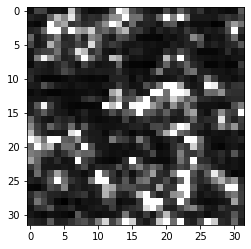

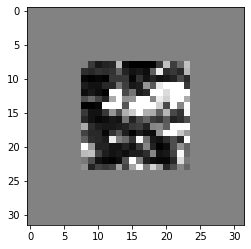

In [16]:
# make it use only a small window inside a larger window
plt.figure()
plt.imshow(aa[-1,:,:],cmap=plt.cm.gray)

aa *= mask

aa = normalize_intensity(aa)
bb = normalize_intensity(bb)

plt.figure()
plt.imshow(aa[-1,:,:],cmap=plt.cm.gray)

In [17]:
c1 = fft_correlate_strided_images(aa,bb)

In [18]:
c.shape, c1.shape

((660, 63, 63), (660, 63, 63))

In [19]:
n_rows, n_cols = get_field_shape(frame_a.shape, window_size=search_size, overlap=overlap)

In [20]:
u1,v1 = correlation_to_velocity(c1,n_rows,n_cols,search_area_size=search_size)

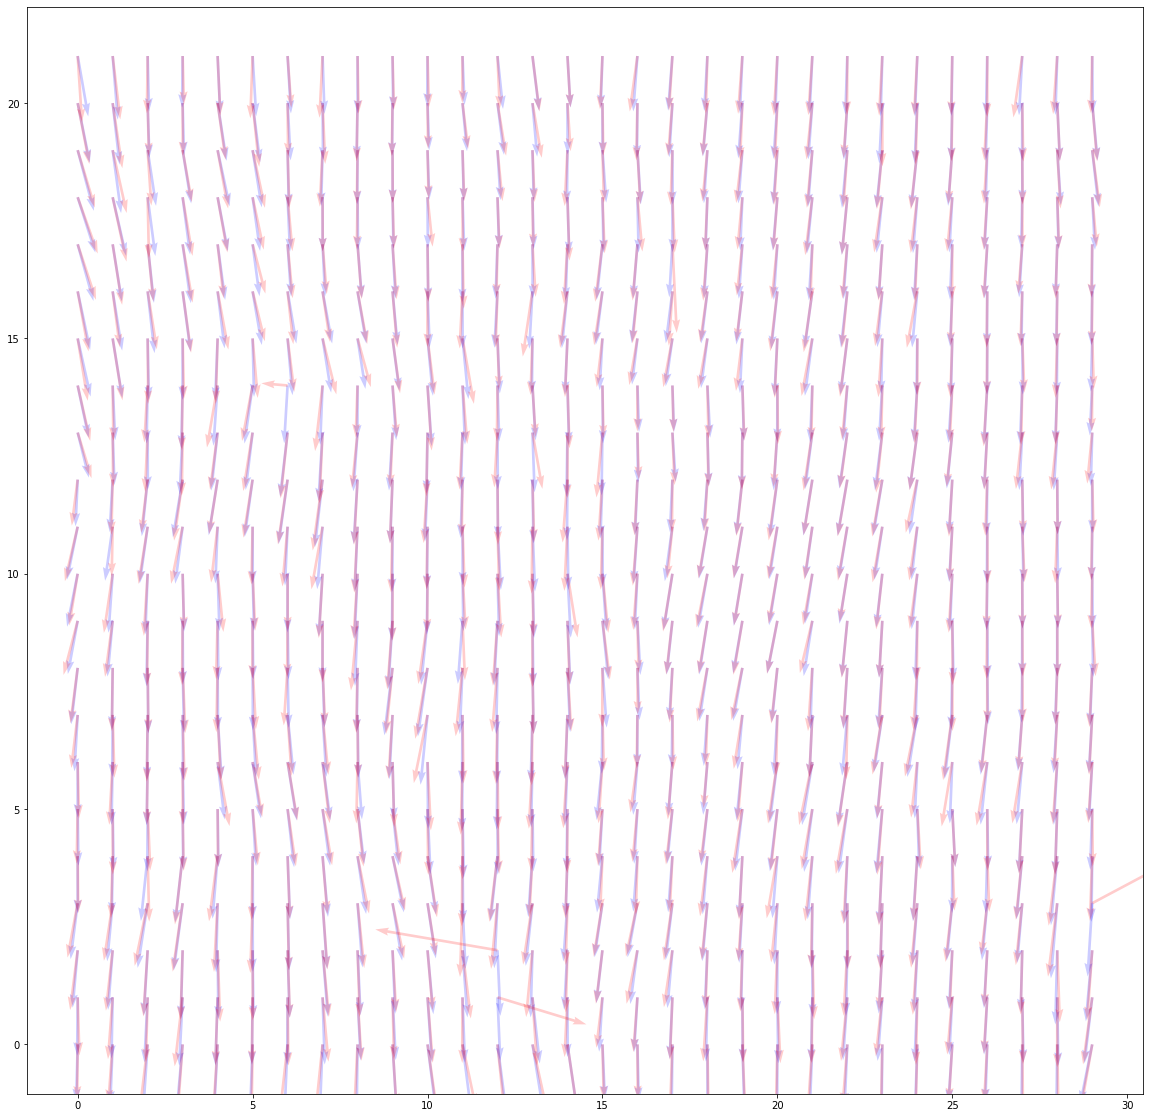

In [21]:
plt.figure(figsize=(20,20))
plt.quiver(u,v,scale=100,color='b',alpha=0.2)
plt.quiver(u1,v1,scale=100,color='r',alpha=0.2)